In [1]:
import os
import pandas as pd
from glob import glob
import pickle

In [2]:
proj_dict = {
    'clip': {
        'TB_fire_clip.csv': {
            'Project': 'FIRE',
            'ID': 'Transect ID',
            'Date': 'Date',
            'gps_E': 'Mean.GPS_E.Biomass',
            'gps_N': 'Mean.GPS_N.Biomass',
            'bm_gm2': 'Total_Weight_(g/m^2)'
        },
        'TB_nex_clip.csv': {
            'Project': 'NEX',
            'ID': 'Transect ID',
            'Date': 'Date_cln',
            'gps_E': 'Mean.GPS_E.Biomass',
            'gps_N': 'Mean.GPS_N.Biomass',
            'bm_gm2': 'Total Weight (g/m^2)'
        },
        'TB_pdog_clip.csv': {
            'Project': 'PDOG',
            'ID': 'point',
            'Date': 'date',
            'gps_E': 'Mean.GPS_E.Biomass',
            'gps_N': 'Mean.GPS_N.Biomass',
            'bm_gm2': 'Total_Weight_(g/m^2)'
        },
        'TB_wtgn_clip.csv': {
            'Project': 'WTGN',
            'ID': 'Join_ID',
            'Date': 'Date',
            'gps_E': 'Mean.GPS_E.Biomass',
            'gps_N': 'Mean.GPS_N.Biomass',
            'bm_gm2': 'Total Weight (g/m^2)',
        }},
    'vor': {
        'TB_duch_vor.csv': {
            'Project': 'BIRD',
            'ID': 'Point',
            'Date': 'Veg_date',
            'gps_E': 'Easting',
            'gps_N': 'Northing'
        },
        'TB_nex_vor.csv': {
            'Project': 'NEX',
            'ID': 'Transect ID',
            'Date': 'Date',
            'gps_E': 'Mean.GPS_E.Biomass',
            'gps_N': 'Mean.GPS_N.Biomass'
        },
        'TB_pdog_vor.csv': {
            'Project': 'PDOG',
            'ID': 'point',
            'Date': 'date',
            'gps_E': 'Mean.GPS_E.Biomass',
            'gps_N': 'Mean.GPS_N.Biomass'
        },
        'TB_wtgn_vor.csv': {
            'Project': 'WTGN',
            'ID': 'Join_ID',
            'Date': 'Date',
            'gps_E': 'Mean.GPS_E.Biomass',
            'gps_N': 'Mean.GPS_N.Biomass'
        }
    }
    
}

In [3]:
clipLIST = glob('./data/clip/*.csv')
vorLIST = glob('./data/vor/*.csv')
with open('./models/vor_linreg_dx_ix_20250506.pk', 'rb') as f:
    vor_to_bm = pickle.load(f)

In [4]:
df_bm = None
for m in proj_dict:
    print(m)
    for f in proj_dict[m]:
        print(f)
        df_tmp = pd.read_csv(os.path.join('./data', m, f))
        df_out_tmp = df_tmp[[proj_dict[m][f]['ID'],
                             proj_dict[m][f]['Date'],
                             proj_dict[m][f]['gps_E'],
                             proj_dict[m][f]['gps_N']]].copy(deep=True)
        df_out_tmp.columns = ['ID', 'Date', 'gps_E', 'gps_N']
        if m == 'vor':
            bm_vals_tmp = vor_to_bm.predict(df_tmp)**2
            df_out_tmp.loc[:, 'bm_gm2'] = bm_vals_tmp
        else:
            bm_vals_tmp = df_tmp[proj_dict[m][f]['bm_gm2']]
            df_out_tmp.loc[:, 'bm_gm2'] = bm_vals_tmp
        df_out_tmp.loc[:, 'Project'] = proj_dict[m][f]['Project']
        df_out_tmp.loc[:, 'Method'] = m
        if df_bm is None:
            df_bm = df_out_tmp
        else:
            df_bm = pd.concat([df_bm, df_out_tmp])

clip
TB_fire_clip.csv
TB_nex_clip.csv
TB_pdog_clip.csv
TB_wtgn_clip.csv
vor
TB_duch_vor.csv
TB_nex_vor.csv
TB_pdog_vor.csv
TB_wtgn_vor.csv


In [5]:
### drop remaining duplicates. only one exists at ID == '35mm-l-in'
# first sort by x-coordinate to keep western-most transect
df_bm = df_bm.sort_values('gps_E', ascending=True)
# drop duplicates, keeping first after sort
df_bm = df_bm.drop_duplicates(subset=['ID', 'Date', 'Project', 'Method'], keep='first')
# resort dataframe
df_bm = df_bm.sort_values(['Project', 'ID', 'Date', 'Method'])

In [6]:
df_bm['Date'] = pd.to_datetime(df_bm['Date'])

In [7]:
df_bm

,ID,Date,gps_E,gps_N,bm_gm2,Project,Method
0,C1.1,2015-07-23,486913.0,4813259.0,24.123673,BIRD,vor
1,C1.1,2016-06-29,486913.0,4813259.0,34.224050,BIRD,vor
2,C1.1,2017-07-06,486913.0,4813259.0,70.587452,BIRD,vor
3,C1.1,2018-06-18,486913.0,4813259.0,124.063960,BIRD,vor
4,C1.1,2019-06-13,486913.0,4813259.0,154.753580,BIRD,vor
...,...,...,...,...,...,...,...
542,middle_lake_creek_Pt55_No,2022-08-08,NaN,NaN,51.296267,WTGN,vor
543,middle_lake_creek_Pt59_No,2022-08-08,NaN,NaN,193.408029,WTGN,vor
544,middle_lake_creek_Pt60_No,2022-08-08,NaN,NaN,160.443204,WTGN,vor
353,middle_lake_creek_Pt76_No,2022-06-15,NaN,NaN,89.574349,WTGN,vor


In [8]:
# compare VOR vs. Clip when both are available
df_bm_comp = df_bm[df_bm.duplicated(subset=['ID', 'Date', 'Project', 'gps_E', 'gps_N'],
                                    keep=False)].pivot(index=['ID', 'Date', 'Project'], 
                                                       columns='Method',
                                                       values='bm_gm2').reset_index()
df_bm_comp['Year'] = df_bm_comp['Date'].dt.year

Method,clip,vor
Method,,
clip,1.000000,0.787299
vor,0.787299,1.000000


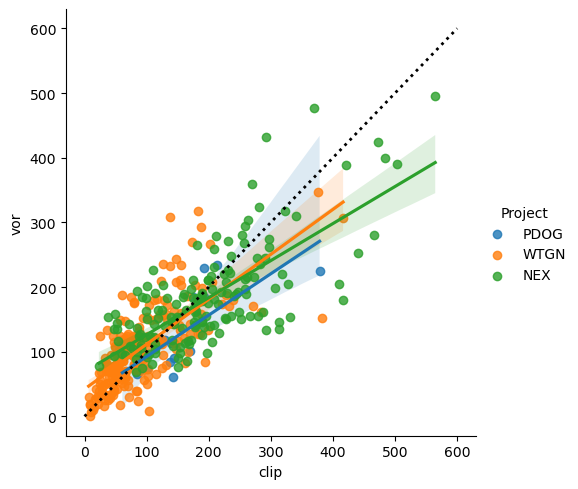

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lmplot(x='clip', y='vor', hue='Project', data=df_bm_comp)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')
df_bm_comp[['clip', 'vor']].corr()

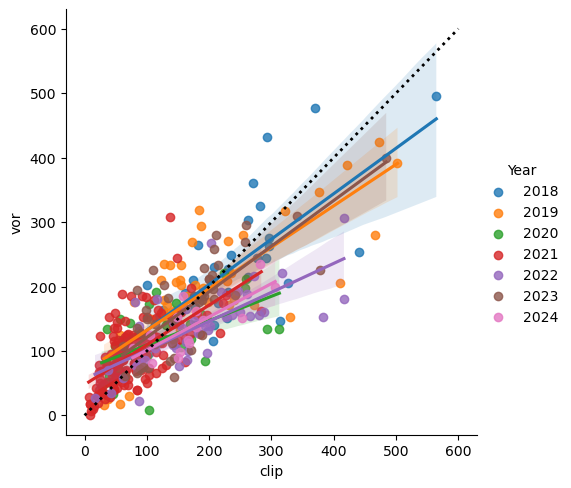

In [10]:
sns.lmplot(x='clip', y='vor', hue='Year', data=df_bm_comp)
plt.plot([0, 600], [0, 600], linewidth=2, c='black', linestyle='dotted')

In [11]:
#df_bm = df_bm.groupby(['ID', 'Date', 'Project', 'gps_E', 'gps_N']).mean().reset_index()
df_bm = df_bm.groupby(['ID', 'Date', 'Project', 'gps_E', 'gps_N', 'Method']).mean().reset_index()

In [12]:
df_bm.to_csv('./data/bm_extract/TB_all_bm.csv', index=False)